## CNN 

In [1]:
import numpy as np 
np.random.seed(10)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import Functions as func
import var
import Viz


Using plaidml.keras.backend backend.


In [2]:
### best is model weights 2

In [3]:
def get_conv_model_normal(dim):
    inp_shape = dim
    act = 'relu'
    drop = .25
    kernal_reg = regularizers.l1(.001)
    dil_rate = 2
    optimizer = Adam(lr = .001)
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
#     model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
#     model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(drop))

    model.add(Dense(3, activation='softmax', name = 'Output_Layer'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model 


In [4]:
x_train, x_test, y_train, y_test = func.get_samples('normal', edge = False)


In [5]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(6512, 150, 150, 3) (724, 150, 150, 3)
(6512, 3) (724, 3)


In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


augment = True 


early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('../models/CNNOriginal-ModelCheckpointWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')
epochs = 100
batch_size = 32
if var.img_type == 'grey': 
    dim = (x_train.shape[1], x_train.shape[2], 1)
else: 
    dim = (x_train.shape[1], x_train.shape[2], 3)
    
normal_model = get_conv_model_normal(dim =dim)

if augment: 
    augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                           horizontal_flip = True, shear_range = .15, 
                                     fill_mode = 'nearest', zoom_range = .15)
    augmentation.fit(x_train)
    normal_history = normal_model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)
else: 
    
    normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/100
204/204 [==============================] - 58s 286ms/step - loss: 4.0782 - acc: 0.6365 - val_loss: 1.6571 - val_acc: 0.7238

Epoch 00001: val_loss improved from inf to 1.65714, saving model to ../models/CNNOriginal-ModelCheckpointWeights.h5
Epoch 2/100
204/204 [==============================] - 34s 164ms/step - loss: 1.4183 - acc: 0.7174 - val_loss: 1.1911 - val_acc: 0.7362

Epoch 00002: val_loss improved from 1.65714 to 1.19110, saving model to ../models/CNNOriginal-ModelCheckpointWeights.h5
Epoch 3/100
204/204 [==============================] - 34s 164ms/step - loss: 1.1697 - acc: 0.7200 - val_loss: 1.0422 - val_acc: 0.7445

Epoch 00003: val_loss improved from 1.19110 to 1.04216, saving model to ../models/CNNOriginal-ModelCheckpointWeights.h5
Epoch 4/100
204/204 [==============================] - 34s 166ms/step - loss: 1.0615 - acc: 0.7249 - val_loss: 0.9789 - val_acc: 0.7555

Epoch 00004: val_loss improved from 1.04216 to 0.97890, saving model to ../models/CNNOriginal-Mo

204/204 [==============================] - 33s 164ms/step - loss: 0.5947 - acc: 0.7768 - val_loss: 0.5953 - val_acc: 0.7459

Epoch 00035: val_loss did not improve from 0.56260
Epoch 36/100
204/204 [==============================] - 33s 164ms/step - loss: 0.5936 - acc: 0.7785 - val_loss: 0.5752 - val_acc: 0.7707

Epoch 00036: val_loss did not improve from 0.56260
Epoch 37/100
204/204 [==============================] - 33s 163ms/step - loss: 0.5890 - acc: 0.7765 - val_loss: 0.5513 - val_acc: 0.7735

Epoch 00037: val_loss improved from 0.56260 to 0.55133, saving model to ../models/CNNOriginal-ModelCheckpointWeights.h5
Epoch 38/100
204/204 [==============================] - 33s 164ms/step - loss: 0.5910 - acc: 0.7794 - val_loss: 0.5730 - val_acc: 0.7610

Epoch 00038: val_loss did not improve from 0.55133
Epoch 39/100
204/204 [==============================] - 34s 165ms/step - loss: 0.5923 - acc: 0.7754 - val_loss: 0.5526 - val_acc: 0.7680

Epoch 00039: val_loss did not improve from 0.55133

In [7]:
print(normal_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Conv2D)         (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
__________

### Loss & Accuracy

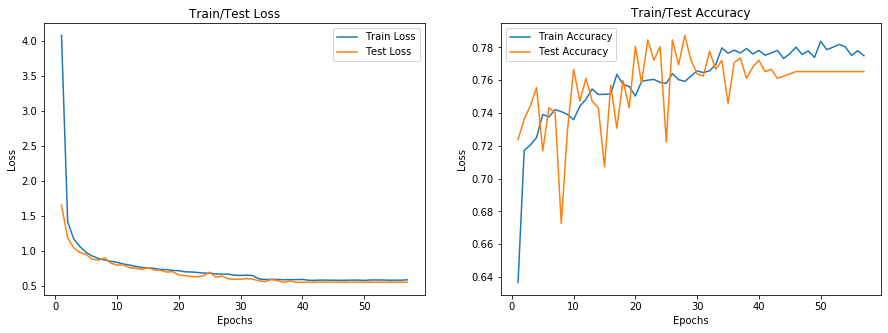

In [8]:
Viz.plot_loss_accuracy(normal_history)

### AUC and ROC Curves

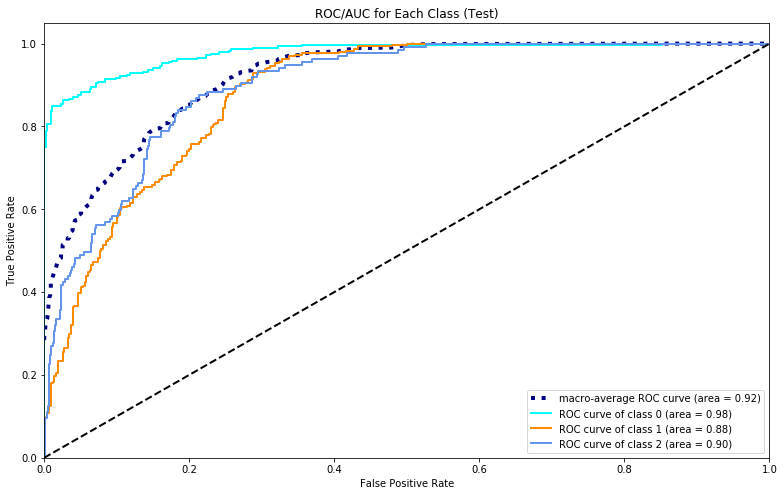

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9010600706713779
HandGun: 0.7378640776699029
Rifle: 0.5833333333333334


In [9]:
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNNOriginal-ModelCheckpointWeights.h5') #load the best weights before overfitting
 


    
Viz.plot_roc_auc(normal_model, x_test, y_test)

### Confusion Matrix

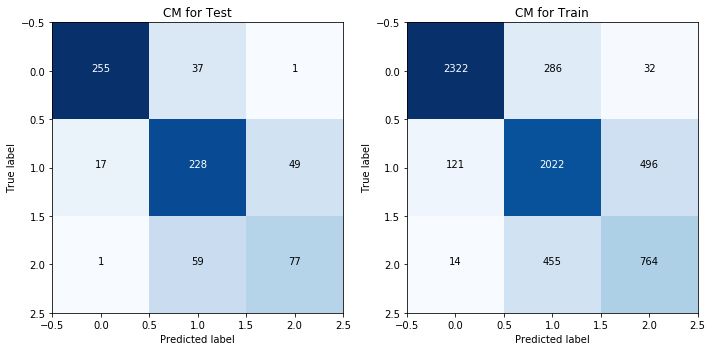

In [10]:
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNNOriginal-ModelCheckpointWeights.h5') #load the best weights before overfitting





y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'])


In [ ]:
assert False

#### Test on Google Data


In [11]:
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [13]:
base_path = '../Tests/Photos'

if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNNOriginal-ModelCheckpointWeights.h5')


for file in os.listdir(base_path): 
    if file == '.ipynb_checkpoints':
        continue
    full_path = f'{base_path}/{file}'
    img = func.get_image_value(full_path, var.norm_dimension)    
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    pred = normal_model.predict(img)[0]
    print(f'{file}\t\t{np.argmax(pred)}\t\t{pred.max()}\t\t{pred}')

AR.jpg		2		0.7018832564353943		[0.00571655 0.2924001  0.70188326]
NonGun.jpeg		2		0.7189356088638306		[0.00707595 0.27398843 0.7189356 ]
NonGun2.jpg		1		0.5378767848014832		[0.04762768 0.5378768  0.41449556]
Pistol.jpg		1		0.9378839135169983		[5.6344306e-05 9.3788391e-01 6.2059749e-02]
Pistol2.jpg		2		0.9628041982650757		[6.6259131e-06 3.7189104e-02 9.6280420e-01]
Pistol3.jpg		1		0.607141375541687		[0.00332554 0.6071414  0.389533  ]
Pistol4.jpg		1		0.6039082407951355		[0.01144452 0.60390824 0.38464728]
Pistol4.png		2		0.5639929175376892		[0.03841764 0.39758942 0.5639929 ]


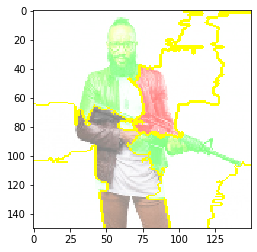

In [14]:
#model 3

img = func.get_image_value('../Tests/Photos/AR.jpg', var.norm_dimension, var.img_type)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, normal_model.predict, top_labels = 5, hide_color = 0, 
                                         num_samples = 2000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries(temp/2 + .5, mask))

In [19]:
img = func.get_img_prediction_bounding_box('../Tests/Photos/Pistol4.jpg', normal_model, var.norm_dimension)

../Tests/Photos/Pistol4.jpg		1||Handgun		0.6039082407951355		[0.01144452 0.60390824 0.38464728]


In [ ]:
def get_img_prediction_bounding_box(path, model, dim):
    np.random.seed(10)
    img = func.get_image_value(path, dim, var.img_type)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    pred = model.predict(img)[0]
    
    category_dict = {0: 'No Weapon', 1: 'Handgun', 2: 'Rifle'}
    cat_index = np.argmax(pred)
    cat = category_dict[cat_index]
    
    print(f'{path}\t\t{cat_index}||{cat}\t\t{pred.max()}\t\t{pred}')
    
    
    img = cv2.imread(path)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
#     ss.switchToSelectiveSearchQuality()

    rects = ss.process() 

    windows = []
    locations = []
    for x, y, w,h in rects[:2000]: 
        startx = x 
        starty = y 
        endx = x+w 
        endy = y+h 
        roi = img[starty:endy, startx:endx]
        roi = cv2.resize(roi, dsize =dim, interpolation = cv2.INTER_CUBIC)
        windows.append(roi)
        locations.append((startx, starty, endx, endy))

    windows = np.array(windows)

    predictions = model.predict(windows)
    clone = img.copy()
    clone2 = img.copy()
    cat_predictions = predictions[:,cat_index]
    pred_max_idx = np.argmax(cat_predictions)
    pred_max = cat_predictions[pred_max_idx]
    
    pred_max_window = locations[pred_max_idx]
    startx, starty, endx, endy = pred_max_window
    cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,0,255),2)

    text = f'{cat}'
    cv2.putText(clone, text, (startx, starty), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,0,255),2)
   

    cv2.imshow(f'{cat}', np.hstack([clone, clone2]))
    cv2.waitKey(0)
    ss.clear()
    return clone

In [ ]:
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights1.h5')

pred2 = get_img_prediction_bounding_box('../Tests/Photos/AR.jpg', normal_model, var.norm_dimension)

In [ ]:
assert False

In [ ]:
from tqdm import tqdm
def get_vid_prediction_bounding_box(path, model, dim): 
    vid = cv2.VideoCapture(path)
    total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    pbar = tqdm(total = total_frames, desc = f'Splitting Video Into {total_frames} Frames')
    images = [] 
    sucess =1 
    while True: 
        try:
            success, img = vid.read() 
            img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
            images.append(img)
            pbar.update(1)
        except: 
            break
        

    pbar.close()
    print(total_frames)
    print(np.array(images).shape)
    return np.array(images)
   



images = get_vid_prediction_bounding_box('../Tests/Videos/Pistol2.mp4', normal_model, var.norm_dimension)
predictions = normal_model.predict(images)

In [ ]:
def window_prob_func(pred, img, model, dim):
    category_dict = {0: 'No Weapon', 1: 'Handgun', 2: 'Rifle'}
    cat_index = np.argmax(pred)
    cat = category_dict[cat_index]
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process() 

    windows = []
    locations = []
    for x, y, w,h in rects: 
        startx = x 
        starty = y 
        endx = x+w 
        endy = y+h 
        roi = img[starty:endy, startx:endx]
        roi = cv2.resize(roi, dsize =dim, interpolation = cv2.INTER_CUBIC)
        windows.append(roi)
        locations.append((startx, starty, endx, endy))

    windows = np.array(windows)

    predictions = model.predict(windows)

    clone = img.copy()
    cat_predictions = predictions[:,cat_index]
    pred_max_idx = np.argmax(cat_predictions)
    pred_max = cat_predictions[pred_max_idx]
    
    pred_max_window = locations[pred_max_idx]
    startx, starty, endx, endy = pred_max_window
    
    
    return (cat, pred_max, (startx, starty, endx, endy))

pbar = tqdm(list(zip(predictions, images)), desc= 'Getting Base Prediction and Extracting Sliding Window... Sit Back, This Will Take A While')
windows_prob = [window_prob_func(pred, img, normal_model, var.norm_dimension) for (pred, img) in pbar]

In [ ]:
import pickle 
pickle.dump(windows_prob, open('../Pickles/WindowsPropPistol_CNN.p', 'wb'))

for i in windows_prob: 
    if i[0] != 'No Weapon': 
        print(i)

In [ ]:
vid_dim = (224,224)
vid_dim = var.norm_dimension
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('../Tests/VideoTests/TestCNN.mp4',fourcc, 10, vid_dim)


for (cat, (startx, starty, endx, endy)), img in zip(windows_prob, images): 
    clone = img.copy()
    if cat == 'No Weapon':
#         clone = cv2.resize(clone, dsize =vid_dim, interpolation = cv2.INTER_CUBIC)      
        out.write(clone)
    else: 
        cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,0,255),2)
#         clone = cv2.resize(clone, dsize =vid_dim, interpolation = cv2.INTER_CUBIC)     
        out.write(clone)
out.release()
cv2.destroyAllWindows()

In [ ]:
assert False

In [ ]:
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights2.h5')

img = cv2.imread('../TestImages/AR.jpg')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process() 

windows = []
locations = []
for x, y, w,h in rects: 
    startx = x 
    starty = y 
    endx = x+w 
    endy = y+h 
    roi = img[starty:endy, startx:endx]
    roi = cv2.resize(roi, dsize =var.norm_dimension, interpolation = cv2.INTER_CUBIC)
    windows.append(roi)
    locations.append((startx, starty, endx, endy))
    


In [ ]:
windows = np.array(windows[:2000])

predictions = normal_model.predict(windows)

In [ ]:
# for i in predictions:
#     print(i)

In [ ]:
clone = img.copy()
new_loc = [] 
new_prob = [] 
no_gun = predictions[:, 0].sum()
handgun = predictions[:,1].sum()
rifle = predictions[:,2].sum()
sum_array = np.array([no_gun, handgun, rifle])
index_unit = np.argmax(sum_array)
cat_types = ['No Gun', 'Handgun', 'Rifle']
print(index_unit)
print(no_gun, handgun, rifle)
new_locations = []
for idx, i in enumerate(predictions):
    category = i[index_unit]
    if category > .5:
        startx, starty, endx, endy = locations[idx]
        new_locations.append([startx, starty, endx, endy])
        new_loc.append(locations[idx])
        new_prob.append(category)

new_locations = np.array(new_locations)

startx = int(new_locations[:,0].mean())
starty =int( new_locations[:,1].mean())
endx = int(new_locations[:,2].mean())
endy = int(new_locations[:,3].mean())


# startx = int(np.median (new_locations[:,0]))
# starty =int( np.median (new_locations[:,1]))
# endx = int(np.median (new_locations[:,2]))
# endy = int(np.median(new_locations[:,3]))

prob_avg = np.array(new_prob).mean()


cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)

text = f'{cat_types[index_unit]}: {int(prob_avg*100)}'
cv2.putText(clone, text, (startx, starty), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
   
    
cv2.imshow('test', clone)
cv2.waitKey(0)

In [ ]:
assert False